In [4]:
# ============================================
# || import all necessary libraries         ||
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, List, Tuple, Any

from pyomo.environ import (ConcreteModel, Var, Binary, NonNegativeReals, Set, 
                         Objective, Constraint, SolverFactory, TerminationCondition, 
                         minimize, value, Param)

from utils.data import get_fixed_data
from utils.WindProcess import wind_model
from utils.PriceProcess import price_model

ModuleNotFoundError: No module named 'DMUU'

In [2]:
# ============================================
# || Generate wind and price trajectories   ||
# ============================================

def generate_trajectories(data: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    num_timeslots = data['num_timeslots']
    wind_trajectory = np.zeros(num_timeslots)
    price_trajectory = np.zeros(num_timeslots)
    
    # init first two values
    wind_trajectory[0] = data['target_mean_wind']
    wind_trajectory[1] = data['target_mean_wind']
    price_trajectory[0] = data['mean_price']
    price_trajectory[1] = data['mean_price']
    
    # Generate trajectories
    for t in range(2, num_timeslots):
        wind_trajectory[t] = wind_model(wind_trajectory[t-1], wind_trajectory[t-2], data)
        price_trajectory[t] = price_model(price_trajectory[t-1], price_trajectory[t-2], 
                                        wind_trajectory[t], data)
    
    return wind_trajectory, price_trajectory

In [34]:
# ============================================
# || Solve MILP model                       ||
# || with given wind and price trajectories ||
# ============================================

def solve_milp(wind_trajectory: np.ndarray, price_trajectory: np.ndarray, data: Dict[str, Any], obj: bool): #-> Dict[str, List[float]]:
    m = ConcreteModel()
    
    # Sets and parameters 
    m.T = Set(initialize=range(data['num_timeslots']))
    m.D = Param(m.T, initialize=lambda m, t: data['demand_schedule'][t])
    
    # Variables
    m.x = Var(m.T, within=Binary, initialize=0)
    m.y_on = Var(m.T, within=Binary, initialize=0)
    m.y_off = Var(m.T, within=Binary, initialize=0)
    m.h = Var(m.T, within=NonNegativeReals, initialize=0)
    m.p_grid = Var(m.T, within=NonNegativeReals)
    m.p_p2h = Var(m.T, within=NonNegativeReals)
    m.p_h2p = Var(m.T, within=NonNegativeReals)

    # Constants from data
    R_p2h = data['conversion_p2h']
    R_h2p = data['conversion_h2p']
    C = data['hydrogen_capacity']
    P2H_max = data['p2h_max_rate']
    H2P_max = data['h2p_max_rate']
    C_elzr = data['electrolyzer_cost']
    
    # Objective function
    m.cost = Objective(
        expr=sum(price_trajectory[t] * m.p_grid[t] + C_elzr * m.x[t] 
                 for t in m.T),
        sense=minimize
    )
    
    # Power balance constraint
    def power_balance_rule(m, t):
        return (wind_trajectory[t] + m.p_grid[t] + 
                R_h2p * m.p_h2p[t] - m.p_p2h[t] >= m.D[t])
    m.power_balance = Constraint(m.T, rule=power_balance_rule)
    
    # Power-to-hydrogen limit constraint
    def p2h_limit_rule(m, t):
        return m.p_p2h[t] <= P2H_max * m.x[t]
    m.p2h_limit = Constraint(m.T, rule=p2h_limit_rule)
    
    # Hydrogen-to-power limit constraint
    def h2p_limit_rule(m, t):
        return m.p_h2p[t] <= H2P_max
    m.h2p_limit = Constraint(m.T, rule=h2p_limit_rule)
    
    # Storage balance constraint
    def storage_balance_rule(m, t):
        if t == 0:
            return m.h[t] == 0
        return m.h[t] == (m.h[t-1] + (R_p2h * m.p_p2h[t-1]) * m.x[t-1] - m.p_h2p[t-1])
    m.storage_balance = Constraint(m.T, rule=storage_balance_rule)
    
    # Storage capacity constraint
    def storage_capacity_rule(m, t):
        return m.h[t] <= C
    m.storage_capacity = Constraint(m.T, rule=storage_capacity_rule)
    

# make it into two constraints 

# binary variable x[t] 
# y on 
# y off 
# yon+yoff <= 1
# if electo if of i cant turn of 

    def electrolyzer_rule(m, t):
        return m.y_on[t] + m.y_off[t] <= 1
    m.electrolyzer = Constraint(m.T, rule=electrolyzer_rule)

    def electrolyzer_on_rule(m, t):
        return m.y_on[t] <= m.x[t]
    m.electrolyzer_on = Constraint(m.T, rule=electrolyzer_on_rule)

    def electrolyzer_off_rule(m, t):
        return m.x[t] <= 1 - m.y_off[t]
    m.electrolyzer_off = Constraint(m.T, rule=electrolyzer_off_rule)

    # # State transition constraint
    # def state_transition_rule(m, t):
    #     if t == 0:
    #         return m.x[t] == 0
    #     return m.x[t] == m.x[t-1] + m.y[t-1] - 2 * m.x[t-1] * m.y[t-1]
    # m.state_transition = Constraint(m.T, rule=state_transition_rule)
    
    # Initialize y[0] = 0
    def y_on_init_rule(m, t):
        if t == 0:
            return m.y_on[t] == 0
        return Constraint.Skip
    m.y_on_init = Constraint(m.T, rule=y_on_init_rule)
    def y_off_init_rule(m, t):
        if t == 0:
            return m.y_off[t] == 0
        return Constraint.Skip
    m.y_off_init = Constraint(m.T, rule=y_off_init_rule)
    
    # Solve
    solver = SolverFactory('gurobi')
    results = solver.solve(m)
    if obj:
        return round(value(m.cost),ndigits=2)
    else:
        if results.solver.termination_condition == TerminationCondition.optimal:
            print(f"Optimal cost: {round(value(m.cost),ndigits=2)}")
            return {
                'electrolyzer_status': [value(m.x[t]) for t in m.T],
                'hydrogen_storage_level': [value(m.h[t]) for t in m.T],
                'power_to_hydrogen': [value(m.p_p2h[t]) for t in m.T],
                'hydrogen_to_power': [value(m.p_h2p[t]) for t in m.T],
                'grid_power': [value(m.p_grid[t]) for t in m.T]
            }
        else:
            raise Exception("No optimal solution found")


In [26]:
# ============================================
# || Plot results following template        ||
# ============================================

def plot_results(wind_trajectory: np.ndarray, 
                price_trajectory: np.ndarray, 
                results: Dict[str, List[float]], 
                data: Dict[str, Any], 
                title: str) -> None:
    times = range(data['num_timeslots'])
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(8, 1, 1)
    plt.plot(times, wind_trajectory, label="Wind Power", color="blue")
    plt.ylabel("Wind Power")
    plt.legend()
    plt.title(title)
    
    plt.subplot(8, 1, 2)
    plt.plot(times, data['demand_schedule'], label="Demand Schedule", color="orange")
    plt.ylabel("Demand")
    plt.legend()
    
    plt.subplot(8, 1, 3)
    plt.step(times, results['electrolyzer_status'], label="Electrolyzer Status", color="red", where="post")
    plt.ylabel("El. Status")
    plt.legend()
    
    plt.subplot(8, 1, 4)
    plt.plot(times, results['hydrogen_storage_level'], label="Hydrogen Level", color="green")
    plt.ylabel("Hydr. Level")
    plt.legend()
    
    plt.subplot(8, 1, 5)
    plt.plot(times, results['power_to_hydrogen'], label="p2h", color="orange")
    plt.ylabel("p2h")
    plt.legend()
    
    plt.subplot(8, 1, 6)
    plt.plot(times, results['hydrogen_to_power'], label="h2p", color="blue")
    plt.ylabel("h2p")
    plt.legend()
    
    plt.subplot(8, 1, 7)
    plt.plot(times, results['grid_power'], label="Grid Power", color="green")
    plt.ylabel("Grid Power")
    plt.legend()
    
    plt.subplot(8, 1, 8)
    plt.plot(times, price_trajectory, label="price", color="red")
    plt.ylabel("Price")
    plt.xlabel("Time")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [35]:
result = np.zeros(10)
data = get_fixed_data()
for i in range(10):
    wind1, price1 = generate_trajectories(data)
    result[i] = solve_milp(wind1, price1, data,True)
print(np.mean(result))

521.548


In [43]:
wind1, price1 = generate_trajectories(data)
result = solve_milp(wind1, price1, data,False)

Optimal cost: 615.47


In [44]:
result

{'electrolyzer_status': [-0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  1.0,
  1.0,
  1.0,
  -0.0,
  1.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  0.0],
 'hydrogen_storage_level': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  4.5,
  6.0,
  10.5,
  10.5,
  15.0,
  15.0,
  15.0,
  15.0,
  15.0,
  15.0,
  15.0,
  12.2679295283528,
  8.182993037813898,
  3.7007599907802673,
  0.0],
 'power_to_hydrogen': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  5.0,
  1.6666666666666667,
  5.0,
  0.0,
  5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'hydrogen_to_power': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.7320704716471997,
  4.084936490538904,
  4.48223304703363,
  3.7007599907802673,
  5.0],
 'grid_power': [0.5,
  1.0176380902050415,
  2.585858862841076,
  4.948911928836127,
  5.74

Optimal cost: 267.22


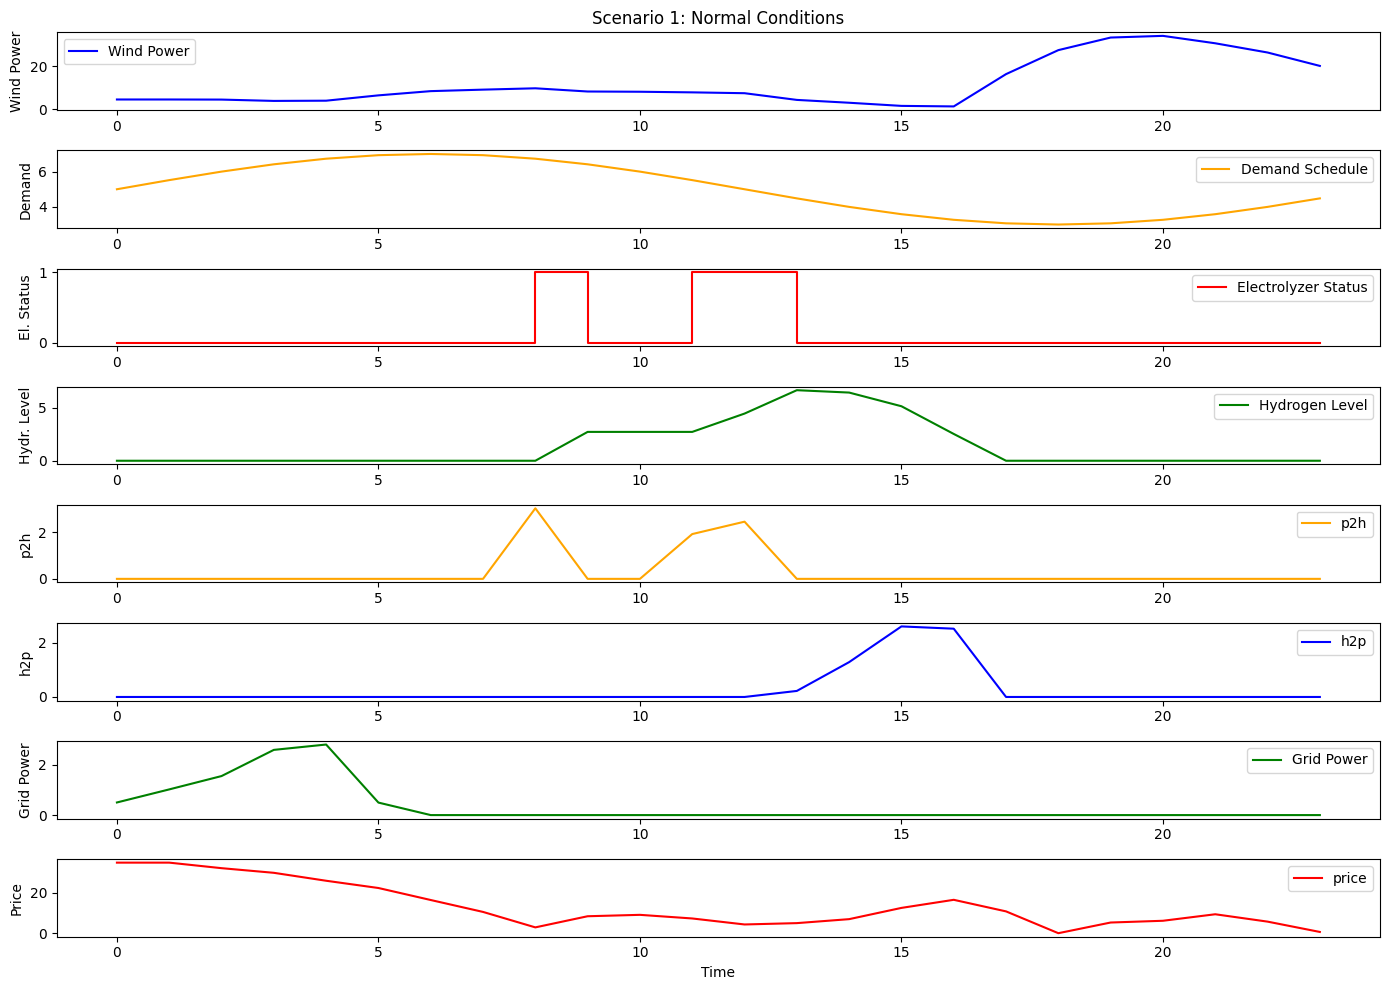

Optimal cost: 526.53


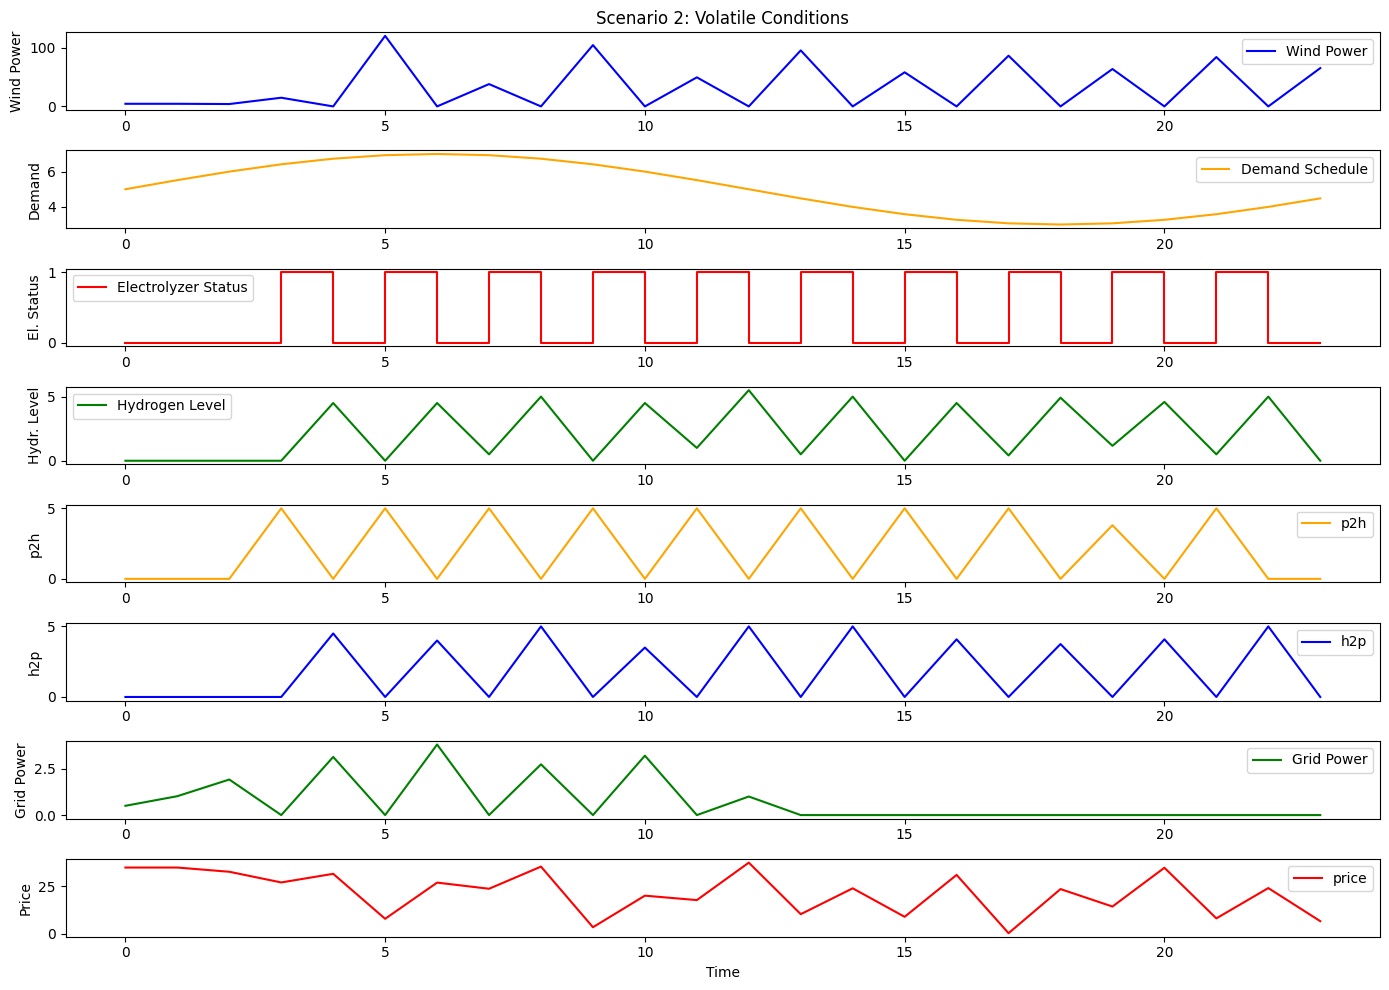

In [21]:
def main() -> None:
    data = get_fixed_data()
    
    # First scenario - Normal conditions
    wind1, price1 = generate_trajectories(data)
    results1 = solve_milp(wind1, price1, data)
    plot_results(wind1, price1, results1, data, "Scenario 1: Normal Conditions")
    
    # Second scenario - More volatile conditions?
    data_volatile = data.copy()
    data_volatile['target_mean_wind'] = data_volatile['target_mean_wind']*200
    data_volatile['price_reversion_strength'] = data_volatile['price_reversion_strength']*10

    wind2, price2 = generate_trajectories(data_volatile)
    results2 = solve_milp(wind2, price2, data)
    plot_results(wind2, price2, results2, data, "Scenario 2: Volatile Conditions")
random.seed(42)
main()